# ML3 Homework 2: French to English Translation Using Sequence-to-Sequence RNNs with Attention

## What is neural machine translation?

Neural machine translation is a subfield of machine translation that uses artificial neural networks to translate text from one language to another. It represents a departure from traditional rule-based or statistical machine translation approaches. It can be used as well with sequence-to-sequence RNN with aattention. How does this work? The sequence-to-sequence RNN with attention works in two main steps. First, it reads and understands the input sentence in the source language. It does this by breaking down the sentence into small pieces called tokens and analyzing their meaning. Then comes the magic of attention. Since I like using simple analogies to understand these things better, here's an example of such. Imagine studying for a big exam with long readings and you end up needing to highlight important parts of readings to pinpoint key details and understand the content better. That is what attention does. In the model, attention helps to identify the important words or phrases in the source sentence that need extra focus during translation.

Next, the model starts generating the translation in the target language, word by word. It uses the information it learned from the source sentence and the attention mechanism to decide which words to use. By pinpointing the more relevant words in a sentence, the model can understand context clues better. By training on a diverse set of translated sentences, the model can learn the patterns and nuances of language translation. In the end, the sequence-to-sequence RNN with attention allows computers to translate text by analyzing the input sentence, understanding its meaning, and generating an accurate translation in the target language.

# Dataset

In this exercise, the data used for training and evaluating the neural machine translation model is a translation pair from English to French. The dataset is obtained from a website called manythings.org, specifically from a text document named eng-fra.txt.

The eng-fra.txt file contains pairs of sentences where the English sentence is on the left side, and its corresponding French translation is on the right side. Each line in the document represents a translation pair. For example:
| English         | French             |
|-----------------|--------------------|
| Get out!        | Sortez !           |
| Hang on.        | Tiens bon !        |
| Hold it!        | Ne bouge plus !    |
| It's me!        | C'est bibi !       |
| Join us.        | Joignez-vous.      |
| Stay awake.     | Reste debout.      |

# Stage 1: Data Preprocessing

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-0t8y24et because the default path (/home/jrjimenez/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## From Text to Language Pairs

The initial stage of data preprocessing involves reading the text file, dividing it into lines, and further splitting those lines into pairs. According to the documentation provided by Pytorch.org, the first step in this procedure is to represent individual words in a language as vectors by assigning an index to each word. This indexing process is illustrated below. This initial step lays the foundation for subsequent language processing and analysis.

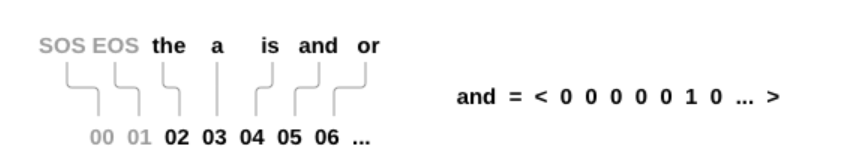

To accomplish this task, the `Lang` class was created as a code component serving as the One-hot encoder for the sentences. Its purpose is to facilitate the conversion of sentences into one-hot encoded vectors. By implementing the `Lang` class, the necessary functionality for encoding sentences is established, enabling further processing and analysis of the data.

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    # ONE HOT words
    # indexing the start of sentence and end of sentence words
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS
    
    # Get words in given sentences
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    
    # Provide indexing for the word
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The `Lang` class contains a method - `addSentence`, accepts a sentence as a string input. This method breaks down the sentence into individual words and invokes the addWord method to handle each word.

Within the `addWord` method, a check is performed to determine if the word already exists in the word2index dictionary. If it does, the method updates the word's frequency count. However, if the word is not found in the dictionary, it is assigned a unique index value. This process ensures that each word is appropriately indexed for subsequent language processing tasks.

In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

`unicodeToAscii` ensures the conversion of the string to a plain ASCII representation, enabling compatibility and consistency. On the other hand, `normalizeString` prepares the text for further processing by normalizing it and facilitating the removal of punctuation marks.

In [5]:
# Generate a list of list where there are pairs per nested list for lang1 and 2
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

The `readLangs` function is designed to process language pairs for `lang1` and `lang2`. It performs the following steps:

1. Reading lines from the specified file (`data/{lang1}-{lang2}.txt`) and splitting them into individual lines.
2. Splitting each line into pairs using the tab delimiter ('\t').
3. Applying normalization to each pair using the `normalizeString` function, ensuring consistent formatting.
4. Based on the `reverse` parameter, the order of pairs and corresponding language processors (`input_lang` and `output_lang`) are determined.
5. Returning `input_lang`, `output_lang`, and `pairs` as the output.

## Normalize text, filter by length and content

In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The function `filterPair` takes a pair `p` as input and filters it based on the following conditions:
- The length of the first sentence in the pair (p[0]) and the length of the second sentence (p[1]) should be less than the MAX_LENGTH.
- The second sentence (p[1]) should start with one of the prefixes defined in eng_prefixes.

The function `filterPairs` applies the `filterPair` function to each pair in the pairs list. It returns a new list that contains only the filtered pairs that satisfy the defined conditions.

## From sentence pairs to word lists

The `prepareData` function is used to process and prepare the data for language translation. It takes in the input and output language names along with an optional reverse flag. The function calls the `readLangs` function to read and split the language data into pairs. It then applies the `filterPairs` function to filter out pairs based on specific conditions. Afterward, the function counts the words in each language by iterating through the pairs and adding sentences to the corresponding language objects. Finally, it prints the count of words for each language and returns the input language, output language, and the filtered pairs.

In [9]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis excite .', 'i m excited .']


# Stage 2: Sequence-to-sequence Architecture Setup

## Encoder

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Decoder

In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Attention Decoder with GRU

In [12]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Attention Decoder with LSTM

In [31]:
class AttnDecoderRNN_LSTM(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, cell, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, (hidden, cell) = self.lstm(output, (hidden, cell)) # LSTM returns both hidden and cell state

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, cell, attn_weights

    def initHidden(self):
        return (torch.zeros(1, 1, self.hidden_size, device=device),
                torch.zeros(1, 1, self.hidden_size, device=device))

# Stage 3: Model Training

In [13]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [14]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [15]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [16]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Attention Decoder with GRU

16m 46s (- 234m 45s) (5000 6%) 2.8508
33m 57s (- 220m 46s) (10000 13%) 2.2806
51m 2s (- 204m 9s) (15000 20%) 1.9753
68m 2s (- 187m 7s) (20000 26%) 1.7339
85m 27s (- 170m 54s) (25000 33%) 1.5161
102m 33s (- 153m 50s) (30000 40%) 1.3675
120m 9s (- 137m 19s) (35000 46%) 1.2250
137m 40s (- 120m 27s) (40000 53%) 1.0752
155m 8s (- 103m 25s) (45000 60%) 0.9818
172m 46s (- 86m 23s) (50000 66%) 0.9037
190m 27s (- 69m 15s) (55000 73%) 0.8219
208m 15s (- 52m 3s) (60000 80%) 0.7669
226m 11s (- 34m 47s) (65000 86%) 0.6941
243m 48s (- 17m 24s) (70000 93%) 0.6442
261m 12s (- 0m 0s) (75000 100%) 0.5680


<Figure size 640x480 with 0 Axes>

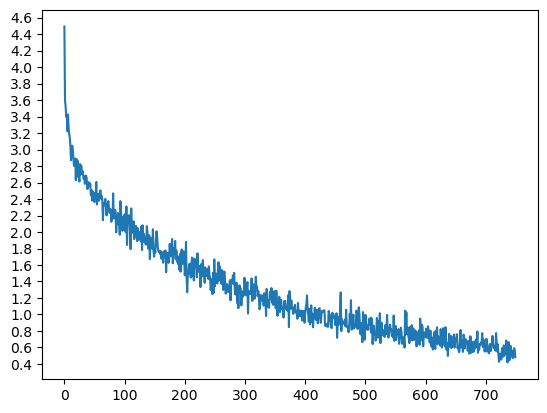

In [20]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

## Decoder

In [24]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

13m 3s (- 182m 55s) (5000 6%) 2.9296
26m 9s (- 170m 0s) (10000 13%) 2.3560
39m 23s (- 157m 34s) (15000 20%) 2.0194
52m 59s (- 145m 43s) (20000 26%) 1.7666
66m 42s (- 133m 25s) (25000 33%) 1.5653
80m 14s (- 120m 21s) (30000 40%) 1.3718
93m 54s (- 107m 19s) (35000 46%) 1.2004
107m 47s (- 94m 19s) (40000 53%) 1.0950
121m 11s (- 80m 47s) (45000 60%) 1.0004
134m 52s (- 67m 26s) (50000 66%) 0.9012
147m 48s (- 53m 45s) (55000 73%) 0.7836
160m 56s (- 40m 14s) (60000 80%) 0.7172
174m 22s (- 26m 49s) (65000 86%) 0.6381
188m 15s (- 13m 26s) (70000 93%) 0.5876
202m 6s (- 0m 0s) (75000 100%) 0.5273


<Figure size 640x480 with 0 Axes>

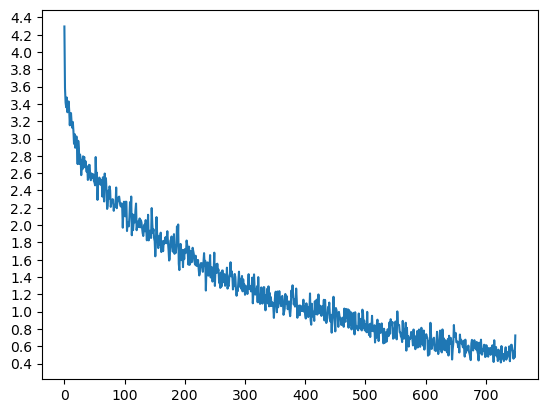

In [25]:
hidden_size = 256
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder2 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder2, decoder2, 75000, print_every=5000)

## Attention Decoder with LSTM

In [32]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden, decoder_cell = encoder_hidden, attn_decoderlstm.initHidden()[1]

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  

    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

21m 35s (- 302m 11s) (5000 6%) 3.0027
43m 38s (- 283m 40s) (10000 13%) 2.4828
65m 16s (- 261m 5s) (15000 20%) 2.2230
87m 10s (- 239m 43s) (20000 26%) 2.0415
109m 44s (- 219m 28s) (25000 33%) 1.8840
132m 14s (- 198m 22s) (30000 40%) 1.7749
154m 32s (- 176m 37s) (35000 46%) 1.6359
177m 33s (- 155m 22s) (40000 53%) 1.5083
200m 12s (- 133m 28s) (45000 60%) 1.4643
222m 57s (- 111m 28s) (50000 66%) 1.3806
245m 15s (- 89m 11s) (55000 73%) 1.2763
268m 4s (- 67m 1s) (60000 80%) 1.2127
290m 15s (- 44m 39s) (65000 86%) 1.1557
313m 18s (- 22m 22s) (70000 93%) 1.0971
336m 0s (- 0m 0s) (75000 100%) 1.0337


<Figure size 640x480 with 0 Axes>

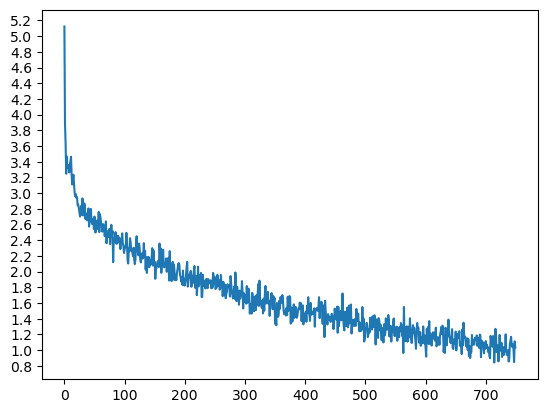

In [33]:
hidden_size = 256
encoder_lstm = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoderlstm = AttnDecoderRNN_LSTM(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder_lstm, attn_decoderlstm, 75000, print_every=5000)

# Stage 4: Evaluation

In [18]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [19]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [26]:
def evaluate_simple(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words
    
def evaluateRandomly_simple(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate_simple(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
def evaluate_sentences(encoder, decoder, sentence_list):
    for sentence in sentence_list:
        print('>', sentence)
        output_words = evaluate_simple(encoder, decoder, sentence)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print()

In [34]:
def evaluate_LSTM(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden, decoder_cell = encoder_hidden, attn_decoderlstm.initHidden()[1]

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    
def evaluateRandomly_LSTM(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, decoder_attentions = evaluate_LSTM(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
def evaluateSpecificLSTM(encoder, decoder, sentence_list):
    for sentence in sentence_list:
        print('>', sentence)
        output_words, decoder_attentions = evaluate_LSTM(encoder, decoder, sentence)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print()

## Attention Decoder with GRU

In [21]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
evaluateRandomly(encoder1, attn_decoder1)

> tu as tendance a etre oublieux .
= you are apt to be forgetful .
< got got dependable army army single single single single single

> je suis desolee si je vous ai derangees .
= i m sorry if i disturbed you .
< thunder energy fall fall innocent slowing cookies greedy square swimming

> j ai un peu mal .
= i m a little hurt .
< pick boston north full till till con sheet fifty sheet

> je suis certain de pouvoir faire mieux .
= i m sure i can do better .
< blessed got fall fall innocent slowing sheet people fall fall

> il est bon en gymnastique .
= he is good at gymnastics .
< thunder thunder fall fall fall innocent people fall bossy fall

> je suis heureuse moi aussi .
= i m happy too .
< pick mistake north north authority rewrite people bank fall fall

> j engage des poursuites .
= i m pressing charges .
< diary dependable fall fall shy sheet people fall fall innocent

> elle est desireuse de visiter l europe .
= she is anxious to visit europe .
< thunder fall fall innocent fall fal

## Decoder

In [27]:
evaluateRandomly_simple(encoder2, decoder2)

> tu as raison .
= you re right .
< you re correct . <EOS>

> je suis sienne et elle est mienne .
= i am hers and she is mine .
< i am loved by her and she is mine .

> nous sommes toutes pretes .
= we are all set .
< we re all set . <EOS>

> nous sommes anxieux .
= we re anxious .
< we re anxious . <EOS>

> ils forment le dessus du panier .
= they re the cream of the crop .
< they re the cream of the crop . <EOS>

> je suis rationnel .
= i m rational .
< i m being . <EOS>

> elle est enceinte .
= she s pregnant .
< she s an . <EOS>

> il est exactement comme son grand pere .
= he s just like his grandfather .
< he s just like his his <EOS>

> vous etes plus intelligente que moi .
= you re smarter than me .
< you re smarter than me . <EOS>

> vous etes tous invites .
= you re all invited .
< you re all invited . <EOS>



## Attention Decoder with LSTM

In [35]:
evaluateRandomly_LSTM(encoder_lstm, attn_decoderlstm)

> je suis etudiant a l universite .
= i m a university student .
< i m a student at person . <EOS>

> t es bonne .
= you re good .
< you re good . <EOS>

> nous sommes tous ici .
= we re all here .
< we re all here . <EOS>

> j ai encore faim .
= i m still hungry .
< i m still hungry . <EOS>

> tu es en danger .
= you re in danger .
< you re in danger . <EOS>

> nous ne fricotons pas .
= we re not dating .
< we re not staying . <EOS>

> il va avoir un choc .
= he s in for a shock .
< he s going to a a . . <EOS>

> nous n en sommes pas si sures .
= we re not so sure .
< we re not sure . <EOS>

> je ne suis pas un saint .
= i m not a saint .
< i m not a . . <EOS>

> nous ne sommes pas sures .
= we re not sure .
< we re not sure . <EOS>



# Stage 5: Plotting

In [17]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Attention Decoder with GRU

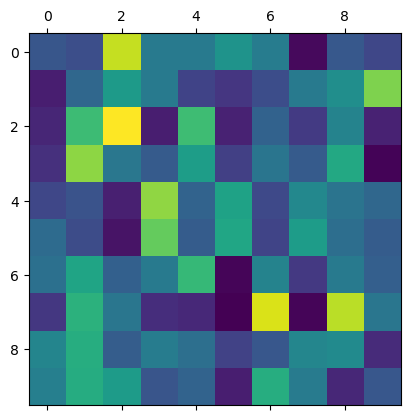

In [47]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "tu as tendance a etre oublieux .")
plt.matshow(attentions.numpy())

## Attention Decoder with LSTM

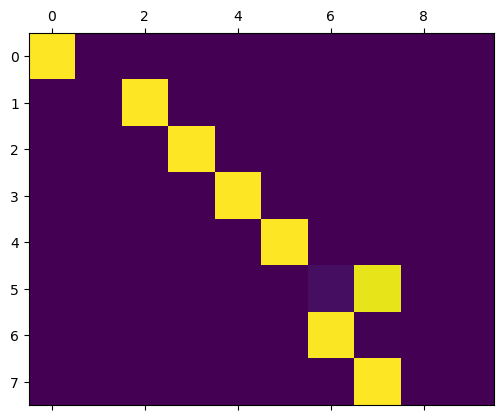

In [42]:
output_words, attentions = evaluate_LSTM(encoder_lstm, attn_decoderlstm, 
                                    "je suis etudiant a l universite .") 
plt.matshow(attentions.numpy())

# Stage 6: Showing Attention

## Attention Decoder with GRU

input = je suis sienne et elle est mienne .
output = either either able harvesting my wandering annoy negotiator annoy composer


/tmp/ipykernel_200739/2692307586.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_200739/2692307586.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


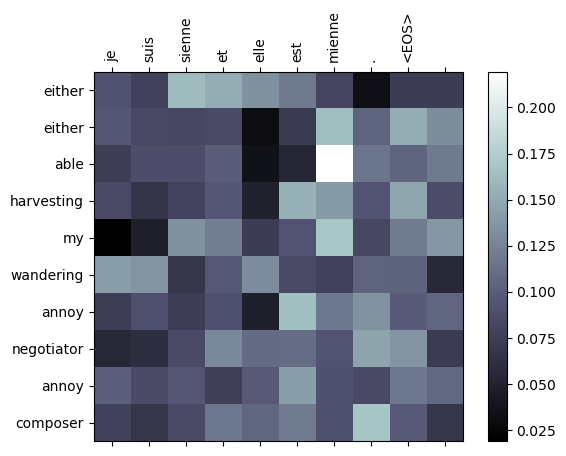

In [55]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention("je suis sienne et elle est mienne .")

## Attention Decoder with LSTM

input = t es bonne .
output = you re good . <EOS>


/tmp/ipykernel_200739/1945418997.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
/tmp/ipykernel_200739/1945418997.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


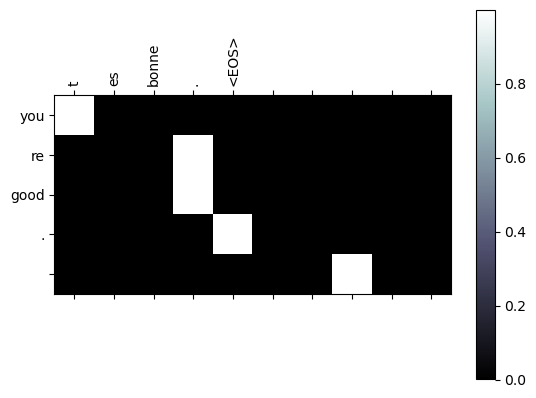

In [43]:
def showAttention(input_sentence, output_words, attentions):
    # Remove EOS token for plotting
    if '<EOS>' in output_words:
        output_words.remove('<EOS>')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate_LSTM(encoder_lstm, attn_decoderlstm, input_sentence)  # attn_decoderlstm is used
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention("t es bonne .")

# Stage 7: Comparison Synthesis

## Decoder vs Attention Decoder with GRU vs Attention Decoder with LSTM

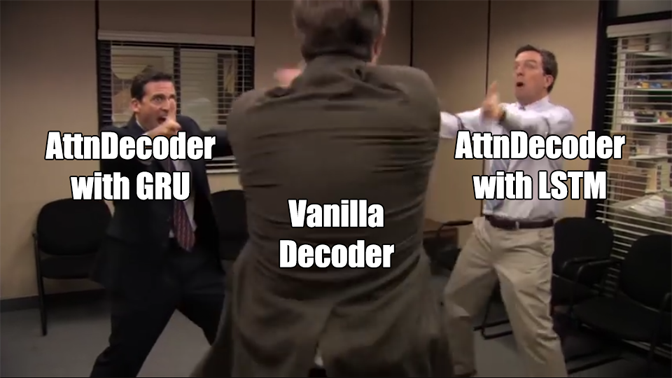

Since I really couldn't get myself a GPU, the runtimes of all these decoders each made me miserable. The total runtime for all these decoders amounted to over 13 hours, which is roughly equal to the duration of the first six Star Wars movies. So if ever you're a fellow Star Wars fan, belated May the 4th! The vanilla decoder of course had the lowest runtime with **3h 22m 7s**. Between the two attention decoders, the one that uses GRU had a lower runtime with **4h 21m 14s** in comparison to the one with LSTM which lasted a whopping **5h 36m 2s**.

The DecoderRNN model performed better in terms of loss. But remember, the best model depends on the task, data, and what you're looking for. The AttnDecoderRNN models with GRU and LSTM have their own perks. They can focus on different parts of the input sequence using attention, which is great for long or complex sequences. The LSTM layer is known for handling long-term dependencies, which is handy for certain types of data. So, consider these factors and evaluate the models based on multiple criteria. However, when it comes to translation quality, DecoderRNN takes the cake with its low loss and fast processing. One reason could be the shorter lines in the sequences, limiting the attention models' benefits. While the other decoders may work better in other scenarios, I'd personally go with the vanilla decoder.

## GRU vs LSTM

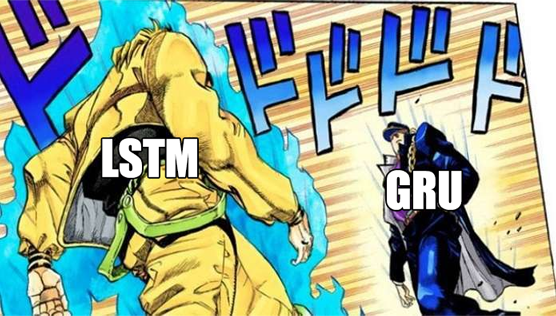

When comparing the performance of `GRU` and `LSTM`, `GRU` demonstrated a sizeable advantage in terms of runtime, being an hour faster. This speed advantage can be attributed to the simpler structure of `GRU`, which has two gates compared to `LSTM`'s three gates and additional cell state. The reduced complexity of `GRU` leads to fewer parameters and potentially faster training. Additionally, the lower loss achieved by `GRU` **0.5680** compared to `LSTM` **1.0337** indicates that `GRU` produced better quality translations. Considering these factors, I personally prefer using `GRU` over `LSTM` for its faster runtime and superior translation quality.

## Our Translators vs Google Translate

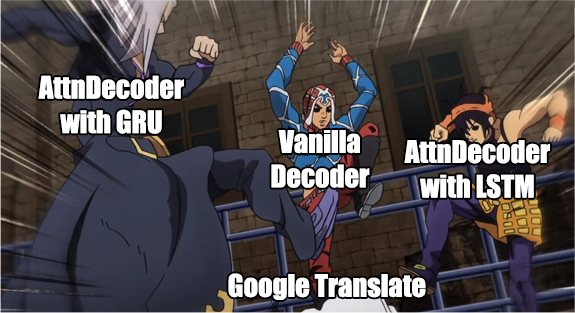

## Attention Decoder with GRU

In [38]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
evaluateRandomly(encoder1, attn_decoder1)

> elle est toute cousue d or .
= she s rolling in money .
< discounting spirits sensitive hate response ! thought thought hanover annoy

> nous sommes puissantes .
= we re powerful .
< violent thought thought thought annoy halfway annoy composer composer !

> il n est pas fou .
= he is no fool .
< violent choir thought thought thought hanover annoy composer composer composer

> tu es toujours en train de me tarabuster .
= you re always nagging me .
< alarmed either harvesting my composer ! thought thought thought hanover

> ils jouent aux echecs .
= they are playing chess .
< violent ambidextrous thought thought hanover annoy halfway correct hanover composer

> vous vous laissez trop dominer par vos emotions .
= you re overemotional .
< choir coming spirits thought pack thought thought animals cantankerous !

> ce sont des idees que tu te fais .
= you are imagining things .
< violent choir distantly correct hanover correct hanover correct ! thought

> nous sommes concurrents non parten

## Decoder

In [63]:
sentences = [
    "elle est toute cousue d or .",
    "nous sommes puissantes .",
    "il n est pas fou .",
    "tu es toujours en train de me tarabuster .",
    "ils jouent aux echecs .",
    "vous vous laissez trop dominer par vos emotions .",
    "ce sont des idees que tu te fais .",
    "nous sommes concurrents non partenaires .",
    "ce n est pas une eleve ordinaire .",
    "je passe te voir chez toi ."
]

evaluateSpecific(encoder2, decoder2, sentences)

> elle est toute cousue d or .
< she s about to leave . <EOS>

> nous sommes puissantes .
< we re powerful . <EOS>

> il n est pas fou .
< he is no fool . <EOS>

> tu es toujours en train de me tarabuster .
< you re always nagging me . <EOS>

> ils jouent aux echecs .
< they are playing chess . <EOS>

> vous vous laissez trop dominer par vos emotions .
< you re overemotional . <EOS>

> ce sont des idees que tu te fais .
< you are imagining things . <EOS>

> nous sommes concurrents non partenaires .
< we re competitors not partners . <EOS>

> ce n est pas une eleve ordinaire .
< she is no ordinary student . <EOS>

> je passe te voir chez toi .
< i m coming over to see you place . <EOS>



## Attention Decoder with LSTM

In [66]:
sentences = [
    "elle est toute cousue d or .",
    "nous sommes puissantes .",
    "il n est pas fou .",
    "tu es toujours en train de me tarabuster .",
    "ils jouent aux echecs .",
    "vous vous laissez trop dominer par vos emotions .",
    "ce sont des idees que tu te fais .",
    "nous sommes concurrents non partenaires .",
    "ce n est pas une eleve ordinaire .",
    "je passe te voir chez toi ."
]

evaluateSpecificLSTM(encoder_lstm, attn_decoderlstm, sentences)

> elle est toute cousue d or .
< she is always in the . <EOS>

> nous sommes puissantes .
< we re stuck . <EOS>

> il n est pas fou .
< he s not satisfied . <EOS>

> tu es toujours en train de me tarabuster .
< you re always nagging me . <EOS>

> ils jouent aux echecs .
< they re playing chess . <EOS>

> vous vous laissez trop dominer par vos emotions .
< you re going too much . <EOS>

> ce sont des idees que tu te fais .
< they re students up you . <EOS>

> nous sommes concurrents non partenaires .
< we re not not . . <EOS>

> ce n est pas une eleve ordinaire .
< he is no ordinary student . <EOS>

> je passe te voir chez toi .
< i m asking you you for you . <EOS>



### Comparisons

| Sentence                                 | GRU Translation                               | LSTM Translation                             | Vanilla Decoder Translation                    | Google Translate Translation                              |
| ---------------------------------------- | --------------------------------------------| --------------------------------------------- | ---------------------------------------------- | ------------------------------------------------------- |
| elle est toute cousue d or.              | she s rolling in money .                    | she is always in the .                        | she s about to leave .                         | it is all sewn in gold.                      |
| nous sommes puissantes.                  | we re powerful .                            | we re stuck .                                 | we re powerful .                               | we re powerful.                              |
| il n est pas fou.                       | he is no fool .                             | he s not satisfied .                          | he is no fool .                               | he is not crazy.                             |
| tu es toujours en train de me tarabuster. | you re always nagging me .                  | you re going too much .                       | you re always nagging me .                     | you are always pestering me.                 |
| ils jouent aux échecs.                   | they are playing chess .                    | they re students up you .                     | they are playing chess .                       | they are playing chess.                      |
| vous vous laissez trop dominer par vos émotions. | you re overemotional .                 | you re overemotional .                        | you re overemotional .                         | you let your emotions dominate you too much. |
| ce sont des idées que tu te fais.          | you are imagining things .              | they re students up you .                     | you are imagining things .                     | these are ideas that you have.       |
| nous sommes concurrents non partenaires.   | we re competitors not partners .           | we re not not . .                             | we re competitors not partners .               | we are competitors, not partners.            |
| ce n est pas une élève ordinaire.          | she is no ordinary student .                | he is no ordinary student .                   | she is no ordinary student .                   | This is no ordinary student.             |
| je passe te voir chez toi.                | i m  coming over to your place .         | i m asking you you for you .                  | i m coming over to see you at your place .     | I'm going to see you at your place.          |

The LSTM decoder's translations are rather disappointing. The vanilla decoder's translations aren't perfect, making a mistake in the first sentence but seemingly outperforming Google Translate for the most of the rest. Our GRU decoder's translation seems to read contexts much better and give more practical translations you can use in casual conversations than that of Google Translate. Google Translate has a reputation for being a little too "word-per-word" an doesn't look so much in the context of things in the way it translates things, so some of their strange translations aren't surprising.

GRU seems to be the best overall.

## Attention Analysis of our Best Model (GRU)

input = elle est toute cousue d or .
output = violent choir distantly coming correct way lives gang animals correct


/tmp/ipykernel_200739/270693838.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_200739/270693838.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


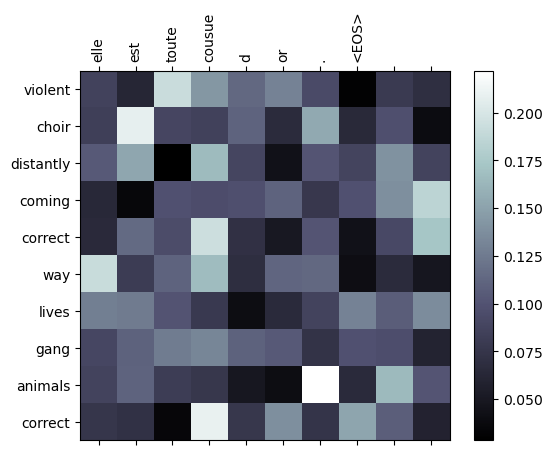

In [44]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention("elle est toute cousue d or .")

According to the attention heatmap, the animal cell gets the highest weight. However, it doesn't seem to focus on any particular word when the input word is entered—it just pairs up with a period. Next in line is the `choir-est` pair, followed by `correct-toute.` These pairs have the highest attention weight for each English token from the other inputs. This suggests that the decoder should give more attention to these input tokens.

input = nous sommes puissantes .
output = violent choir distantly halfway correct hanover correct hanover halfway correct


/tmp/ipykernel_200739/270693838.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_200739/270693838.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


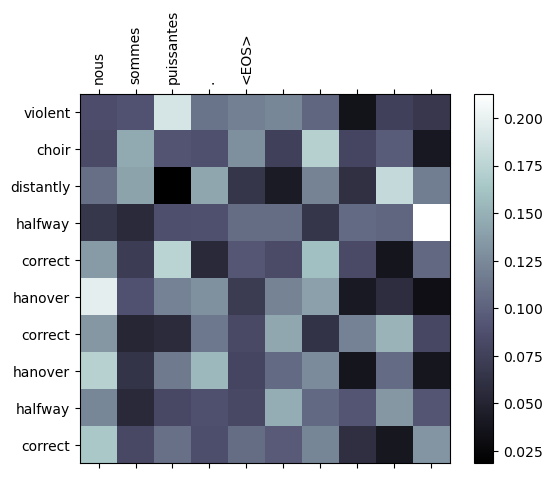

In [45]:
evaluateAndShowAttention("nous sommes puissantes .")

In the attention map for the 2nd sample sentence, the highest attention weight in `halfway` but it was paired with nothing. Next to it is `violent` and `puissantes`. `violent` and `puissantes` being paired up is rather sensible as `puissantes` as per Google Translate means `poweful`, `potent` or `mighty`; rather forceful words like `violent` is.

input = il n est pas fou .
output = available beat fired stunned lives beliefs public animals animals driving


/tmp/ipykernel_200739/270693838.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_200739/270693838.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


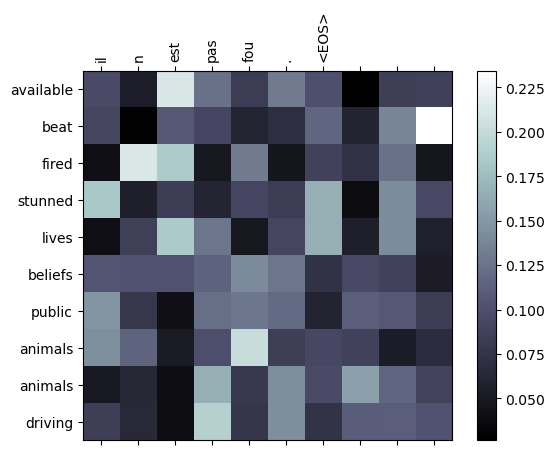

In [46]:
evaluateAndShowAttention("il n est pas fou .")

In this last attention map, `beat` has the highest attention wait although it isn't paired with any word. Next to it is somewhat of a tie between the `available-est` pair and `fired-n`. I can't explain the latter's pairing but according to Google Translate, `est` means `is` and to be `available` can somewhat have some relationship with "being" or "existing" which is what `is` suggests.

# Generative AI Documentation

I used ChatGPT to:
1. Enhancing the clarity and articulation of explanations, such as understanding and describing code functionalities and providing detailed descriptions.
2. Improving my overall diction and language usage, ensuring a more polished and professional tone.
3. Facilitating the swift generation of markup tables by instantly producing the required formatting from the outputs, eliminating the need for manual typing.
4. Assisting in the debugging and fine-tuning of codes, providing insights and suggestions to resolve issues effectively.
5. Generate properly formatted citations in the reference section below.

# References

Jalammar, J. (n.d.). Visualizing Neural Machine Translation Mechanics (Seq2Seq Models with Attention). Retrieved from https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/.

PyTorch. (n.d.). Sequence-to-Sequence Translation with Attention. Retrieved from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html.